In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import seaborn

pd.set_option('display.max_rows', 500)



In [2]:
import re
from scipy.stats import entropy

df = pd.read_csv("../contrastes/provincias.csv", quotechar="\"", decimal=",")
df = df.set_index("palabra")


fnorm_vars = [c for c in df.columns if re.match(r'fnorm_.*', c)]
cant_palabras = [c for c in df.columns if re.match(r'.*Palabras$', c)]
cant_personas = [c for c in df.columns if re.match(r'.*Personas$', c)]

In [3]:
from iv_helpers import simulated_shuffled_entropy_multinomial

fn = lambda ws: simulated_shuffled_entropy_multinomial(ws, len(cant_palabras))

df["entropy_palabras"] = df[cant_palabras].apply(entropy, axis=1, raw=True)
df["entropy_personas"] = df[cant_personas].apply(entropy, axis=1, raw=True)
df["shuffled_entropy_personas"] = df.cantUsuariosTotal.apply(fn)
df["shuffled_entropy_palabras"] = df.cantPalabra.apply(fn)

In [4]:
print df.cantUsuariosTotal.min()
print df.cantPalabra.min()

6
41


In [5]:
cantPalabrasTotales = sum(df.cantPalabra)
df['fnormArgentina'] = df['cantPalabra']/cantPalabrasTotales

In [6]:
df.fnormArgentina


palabra
a                    2.632803e-02
aa                   2.267000e-05
aaa                  8.730575e-05
aaaca                2.387432e-07
aaadentro            3.342405e-07
aaag                 3.979054e-07
aaaggg               3.979054e-07
aaah                 4.978592e-05
aaahh                3.597065e-06
aaahhh               1.037737e-05
aaahi                2.546594e-07
aaahora              2.493540e-07
aaai                 1.522651e-06
aaaii                2.758811e-07
aaaiii               5.889000e-07
aaaj                 6.525648e-07
aaajaja              2.705757e-07
aaajajaja            4.934027e-07
aaajajajaja          4.509594e-07
aaajajajajaja        5.040135e-07
aaajajajajajaja      2.864919e-07
aaajajajajajajaja    2.334378e-07
aaal                 1.596927e-06
aaala                8.541702e-07
aaalgo               9.761946e-07
aaalguien            3.501567e-07
aaall                2.334378e-07
aaalta               1.013332e-06
aaalto               1.050470e-06
aaam  

In [7]:
df.entropy_personas.describe()

count    75878.000000
mean         2.842564
std          0.409441
min          0.000000
25%          2.796571
50%          2.959232
75%          3.059217
max          3.135044
Name: entropy_personas, dtype: float64

## Si le aplico el logaritmo a la cantidad de la Palabra, ya no tiene tanta importancia la cantidad y por lo tanto, las palabras palabras comunes como **que**, **y**, **el**,etc. dejan de tener tanto valor de información

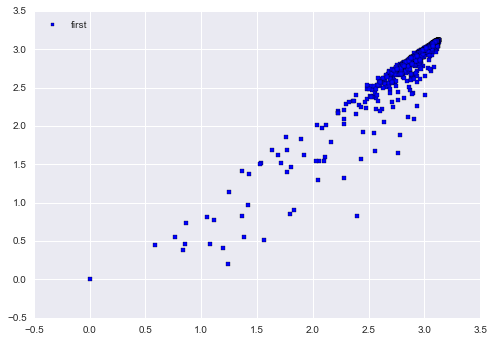

In [8]:
import matplotlib.pyplot as plt

x = df.entropy_personas[:1000]
y = df.entropy_palabras[:1000]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y, s=10, c='b', marker="s", label='first')
plt.legend(loc='upper left');
plt.show()

In [9]:
df.cantPalabra.describe()

count    7.587800e+04
mean     2.484080e+03
std      6.000610e+04
min      4.100000e+01
25%      6.900000e+01
50%      1.390000e+02
75%      4.300000e+02
max      7.509160e+06
Name: cantPalabra, dtype: float64

In [10]:
import math
df['normCantPalabras']=(df.cantPalabra.apply(math.log,args=(2,))-df.cantPalabra.apply(math.log,args=(2,)).min())/(df.cantPalabra.apply(math.log,args=(2,)).max()-df.cantPalabra.apply(math.log,args=(2,)).min())
df['normCantPersonas']=(df.cantUsuariosTotal.apply(math.log,args=(2,))-df.cantUsuariosTotal.apply(math.log,args=(2,)).min())/(df.cantUsuariosTotal.apply(math.log,args=(2,)).max()-df.cantUsuariosTotal.apply(math.log,args=(2,)).min())

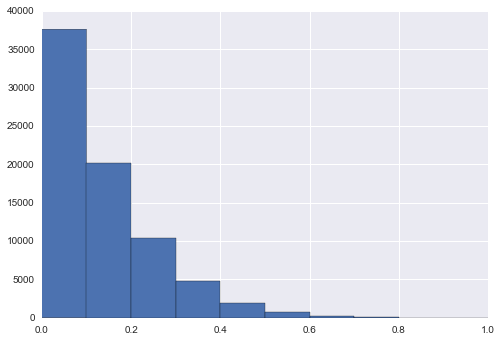

In [11]:
df.normCantPalabras.hist()

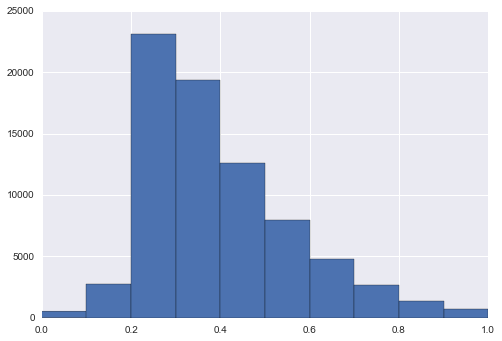

In [12]:
df.normCantPersonas.hist()

In [13]:
from iv_helpers import lugares
places = lugares()
print len(places)
df['esLugar'] = np.where(df.index.str.decode(encoding='utf-8').isin(places),'lugar','ok')

3006


In [42]:
import math

df["information_value_palabras"] = (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_palabras - df.entropy_palabras)
df["information_value_personas"] = (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_personas - df.entropy_personas)
# df["information_value_personas_palabras"] = (df.cantUsuariosTotal.apply(math.log,args=(2,))) * (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)
# df["information_value_personas_palabras"] = df.normCantPalabras * df.normCantPersonas * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)
df["information_value_personas_palabras"] = df.normCantPalabras * df.normCantPersonas * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)

#df["information_value_FnormMax"] = (df.FnormMax) * (df.shuffled_entropy - df.entropy)

df.sort_values(by="information_value_personas_palabras", ascending=False, inplace=True)
df['rankPalabras'] = df['information_value_palabras'].rank(ascending=False).astype('int64')
df['rankPersonas'] = df['information_value_personas'].rank(ascending=False).astype('int64')
df['rankPalabras_Personas'] = df['information_value_personas_palabras'].rank(ascending=False).astype('int64')


palabrasPersonas = [c for c in df.columns if re.match(r'.*PalabrasPersonas', c)]
# df = df.set_index('palabra')
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
df.iloc[:1000][['cantPalabra','esLugar','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas','normCantPersonas','normCantPalabras','shuffled_entropy_personas','entropy_personas']]

,cantPalabra,esLugar,cantUsuariosTotal,provinciaFnormMax,rankPalabras,rankPersonas,rankPalabras_Personas,normCantPersonas,normCantPalabras,shuffled_entropy_personas,entropy_personas
palabra,,,,,,,,,,,
chivilcoy,4074,lugar,469,buenosaires,4,4,1,0.532714,0.379500,3.113115,0.558161
oberá,4322,lugar,378,misiones,3,3,2,0.506352,0.384377,3.107525,0.569656
ushuaia,14966,lugar,1006,tierradelfuego,1,55,3,0.625981,0.486874,3.121280,1.453279
ush,2137,ok,465,tierradelfuego,11,5,4,0.531668,0.326256,3.107593,0.362702
obera,2106,lugar,410,misiones,17,11,5,0.516283,0.325050,3.118679,0.543877
breñas,2590,lugar,170,chaco,6,2,6,0.408690,0.342121,3.092974,0.232404
viedma,6584,lugar,666,rionegro,7,52,7,0.575573,0.419112,3.122884,1.294115
bragado,2805,lugar,294,buenosaires,9,10,8,0.475637,0.348702,3.113184,0.619135
logroño,2592,lugar,132,larioja,5,1,9,0.377771,0.342184,3.043061,0.089018


In [43]:
df.dtypes

buenosairesPalabras                      int64
catamarcaPalabras                        int64
chacoPalabras                            int64
chubutPalabras                           int64
cordobaPalabras                          int64
corrientesPalabras                       int64
entreriosPalabras                        int64
formosaPalabras                          int64
jujuyPalabras                            int64
lapampaPalabras                          int64
lariojaPalabras                          int64
mendozaPalabras                          int64
misionesPalabras                         int64
neuquenPalabras                          int64
rionegroPalabras                         int64
saltaPalabras                            int64
sanjuanPalabras                          int64
sanluisPalabras                          int64
santacruzPalabras                        int64
santafePalabras                          int64
santiagoPalabras                         int64
tierradelfueg

In [15]:
df.sort_values(by='information_value_personas_palabras',ascending=False,inplace=True)
df.iloc[:7000][['cantPalabra','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas']]
df.iloc[:7000][['cantPalabra','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas','entropy_palabras','entropy_personas']].to_csv('resumido.csv')

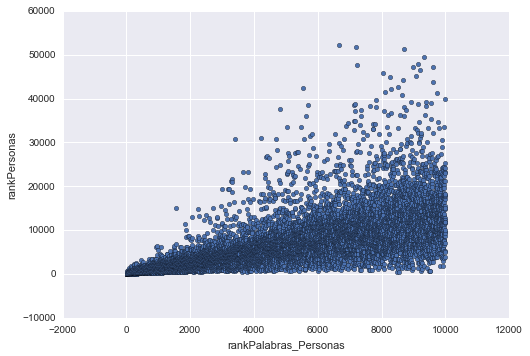

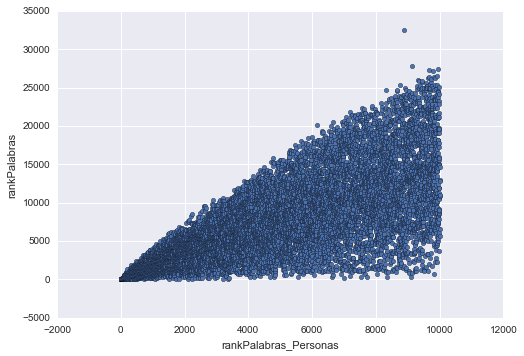

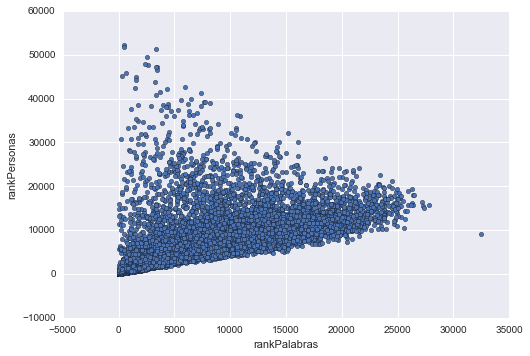

In [16]:
df.iloc[:10000].plot.scatter(x='rankPalabras_Personas',y='rankPersonas')
df.iloc[:10000].plot.scatter(x='rankPalabras_Personas',y='rankPalabras')
df.iloc[:10000].plot.scatter(x='rankPalabras',y='rankPersonas')

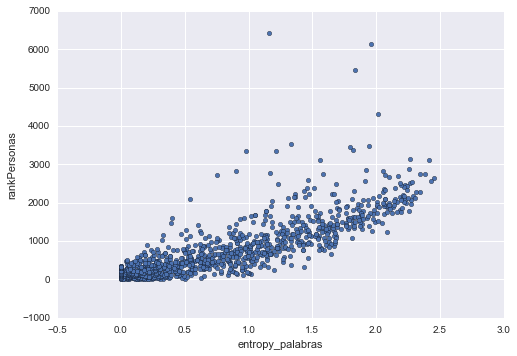

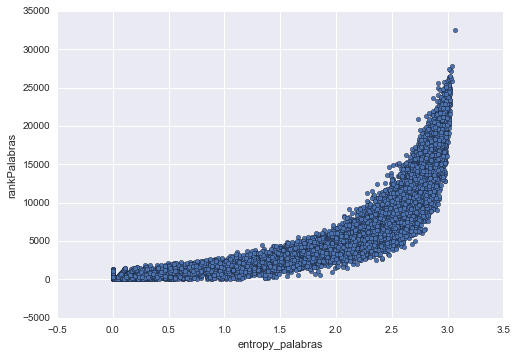

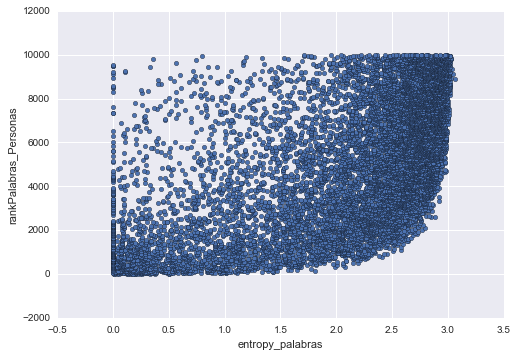

In [17]:
df.iloc[:1000].plot.scatter(x='entropy_palabras',y='rankPersonas')
df.iloc[:10000].plot.scatter(x='entropy_palabras',y='rankPalabras')
df.iloc[:10000].plot.scatter(x='entropy_palabras',y='rankPalabras_Personas')

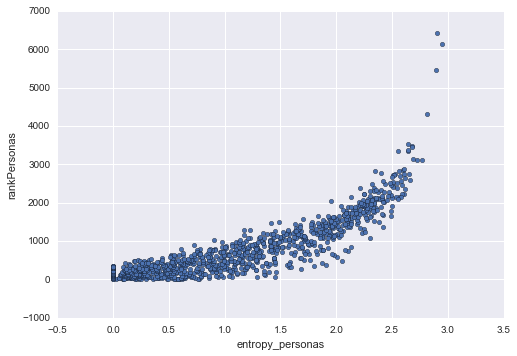

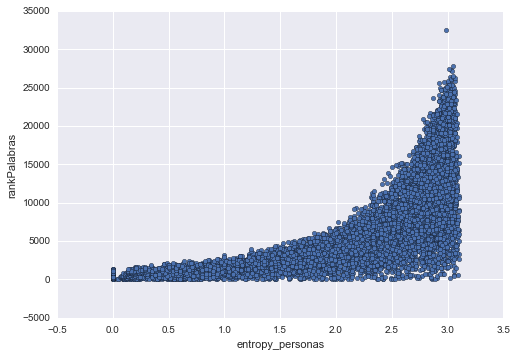

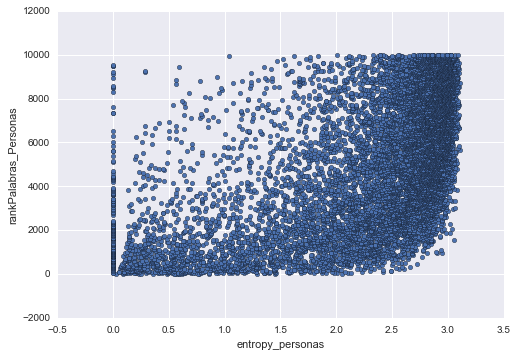

In [18]:
df.iloc[:1000].plot.scatter(x='entropy_personas',y='rankPersonas')
df.iloc[:10000].plot.scatter(x='entropy_personas',y='rankPalabras')
df.iloc[:10000].plot.scatter(x='entropy_personas',y='rankPalabras_Personas')

## Guardo los listados (resumidos, y extendidos) ordenados en base a las dos médidas de información

In [44]:
df.sort_values(by="information_value_palabras", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed.to_csv('ivalue_entropia_palabras_resumida.csv')
df.to_csv('ivalue_entropia_palabras.csv')

df.sort_values(by="information_value_personas", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed.to_csv('ivalue_entropia_personas_resumida.csv')
df.to_csv('ivalue_entropia_personas.csv')

df.sort_values(by="information_value_personas_palabras", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed = resumed[['cantPalabra','esLugar','cantUsuariosTotal','fnormArgentina','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas']]
resumed.to_csv('ivalue_entropia_personas_palabras_resumida.csv')


df.to_csv('ivalue_entropia_personas_palabras.csv')

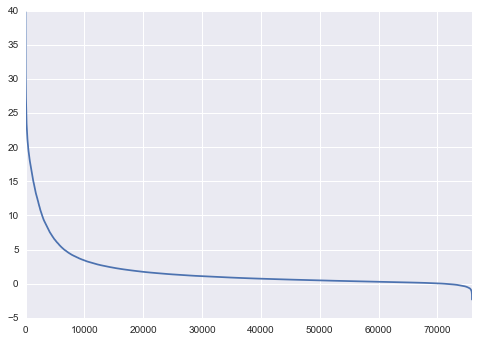

In [20]:
df.sort_values(by="information_value_palabras", ascending=False, inplace=True)
df2 = df.reset_index()
df2.information_value_palabras.plot.line()

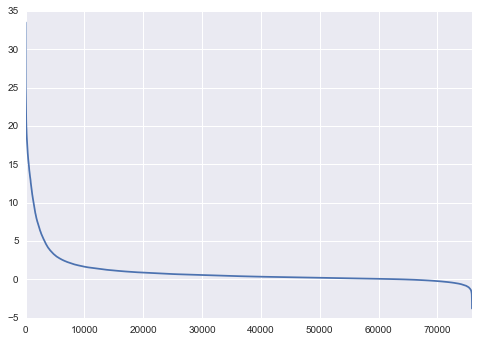

In [21]:
df.sort_values(by="information_value_personas", ascending=False, inplace=True)
df2 = df.reset_index()

df2.information_value_personas.plot.line()

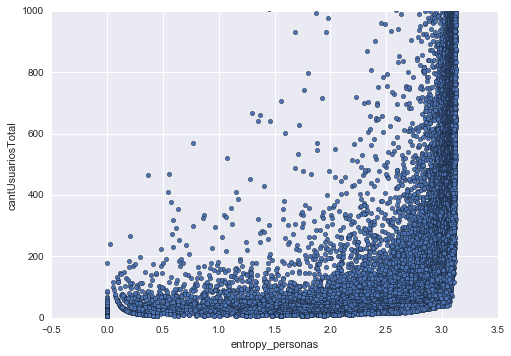

In [22]:
import seaborn
df.plot.scatter(x="entropy_personas", y="cantUsuariosTotal", ylim=[0, 1000])

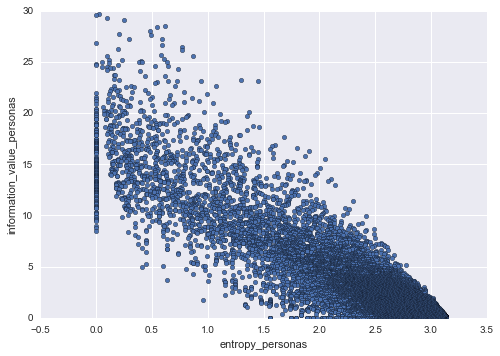

In [23]:
import seaborn
df.plot.scatter(x="entropy_personas", y="information_value_personas", ylim=[0, 30])

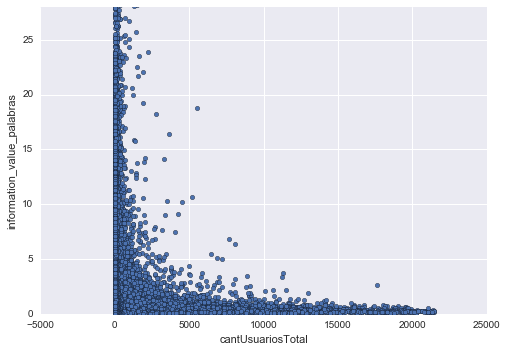

In [24]:
import seaborn
df.plot.scatter(x="cantUsuariosTotal", y="information_value_palabras", ylim=[0, 28])

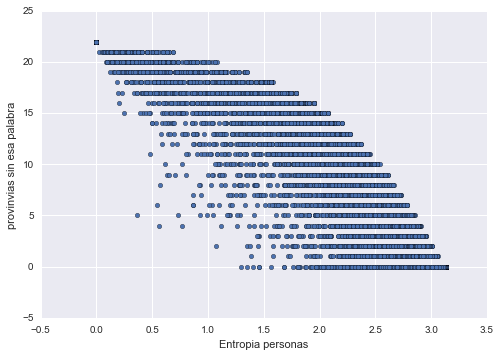

In [25]:
plt.figure(1)
df.plot.scatter(x="entropy_personas", y="provinciaSinEsaPalabra")
plt.xlabel("Entropia personas")
plt.ylabel("provinvias sin esa palabra")


plt.show()


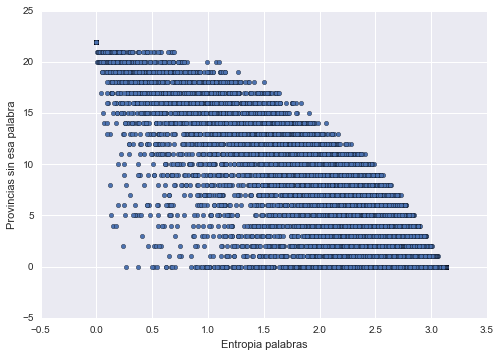

In [26]:

plt.figure(2)
df.plot.scatter(x="entropy_palabras", y="provinciaSinEsaPalabra")
plt.xlabel("Entropia palabras")
plt.ylabel("Provincias sin esa palabra")

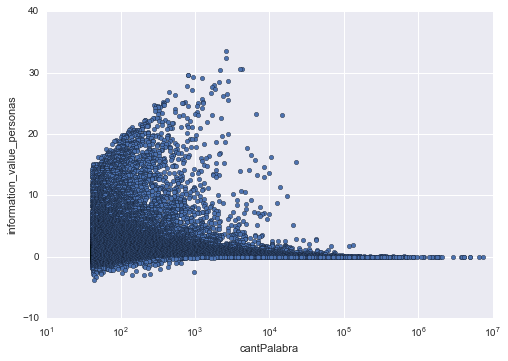

In [27]:
import seaborn
df.plot.scatter(y="information_value_personas", x="cantPalabra", logx=True)

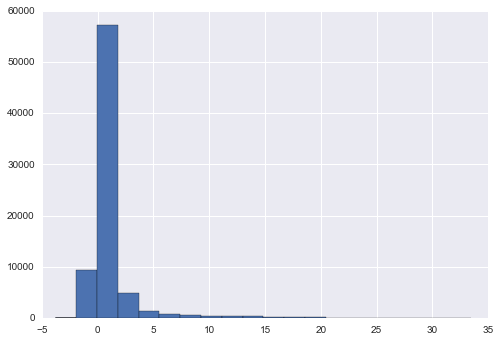

In [28]:
df.information_value_personas.hist(bins=20)

In [29]:
resumed[df.information_value_personas < 0].iloc[:100]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,cantPalabra,esLugar,cantUsuariosTotal,fnormArgentina,provinciaFnormMax,rankPalabras,rankPersonas,rankPalabras_Personas
palabra,,,,,,,,
pobresss,80,ok,78,4.244324e-07,santiago,75831.0,74852.0,26054.0
poderse,56,ok,56,2.971027e-07,sanluis,75868.0,75606.0,26629.0
ronroneo,58,ok,54,3.077135e-07,rionegro,75871.0,75409.0,27390.0
encontraría,81,ok,77,4.297378e-07,jujuy,75580.0,75444.0,28084.0
eliminarlo,98,ok,95,5.199297e-07,formosa,75810.0,73749.0,28548.0
criaron,95,ok,88,5.040135e-07,sanjuan,75497.0,75119.0,28858.0
glynne,51,ok,37,2.705757e-07,chaco,75856.0,75843.0,29065.0
climáticos,59,ok,55,3.130189e-07,jujuy,75805.0,75568.0,29799.0
desmorona,87,ok,84,4.615702e-07,santiago,75448.0,75176.0,30266.0


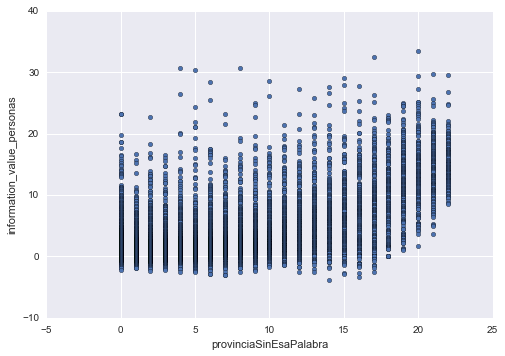

In [30]:
df.plot.scatter(x="provinciaSinEsaPalabra", y="information_value_personas")

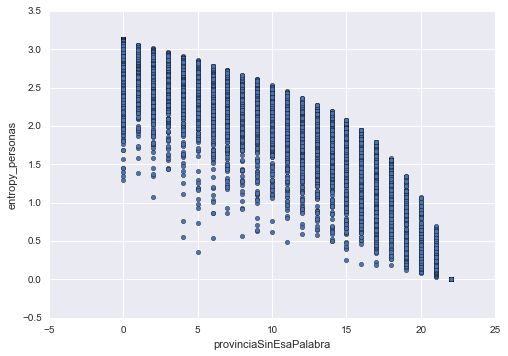

In [31]:
df.plot.scatter(x="provinciaSinEsaPalabra", y="entropy_personas")

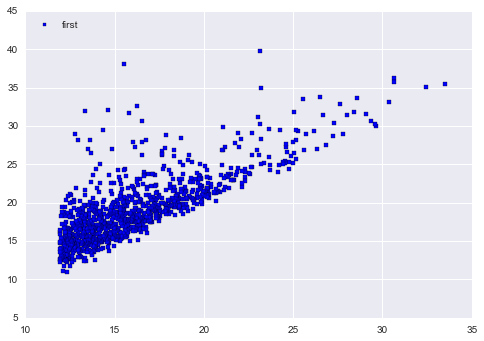

In [32]:
import seaborn
import matplotlib.pyplot as plt

x = df.information_value_personas[:1000]
y = df.information_value_palabras[:1000]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y, s=10, c='b', marker="s", label='first')
plt.legend(loc='upper left');
plt.show()

In [33]:
df[df.provinciaSinEsaPalabra > 17].iloc[:5000][["cantPalabra", "provinciaSinEsaPalabra"]]

,cantPalabra,provinciaSinEsaPalabra
palabra,,
logroño,2592,20
chivil,811,21
ipauss,812,22
sciurano,929,20
plottier,908,20
vallerga,448,22
calahorra,422,21
alvearense,735,20
akil,366,20


In [34]:
df.cantPalabra.apply(math.log,args=(2,)).describe()

count    75878.000000
mean         7.709320
std          2.102951
min          5.357552
25%          6.108524
50%          7.118941
75%          8.748193
max         22.840220
Name: cantPalabra, dtype: float64

In [35]:
(df.shuffled_entropy_personas - df.entropy_personas).describe()

count    75878.000000
mean         0.141867
std          0.336434
min         -0.693147
25%          0.013351
50%          0.050261
75%          0.135214
max          3.068001
dtype: float64

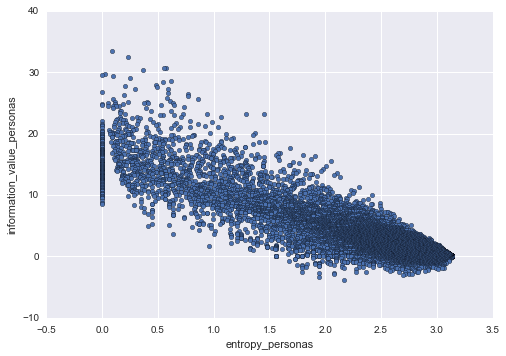

In [36]:
df.plot.scatter(x="entropy_personas", y="information_value_personas")

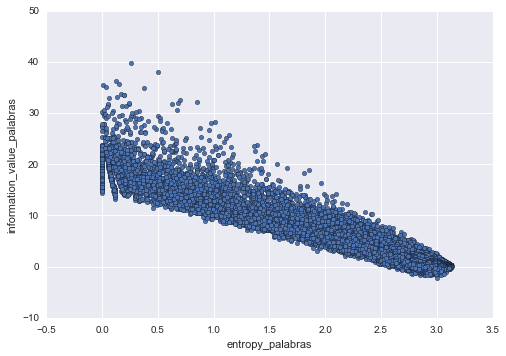

In [37]:
df.plot.scatter(x="entropy_palabras", y="information_value_palabras")

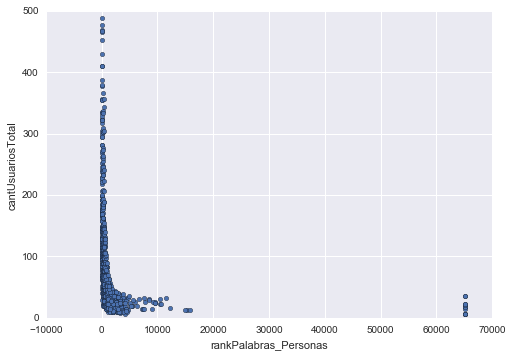

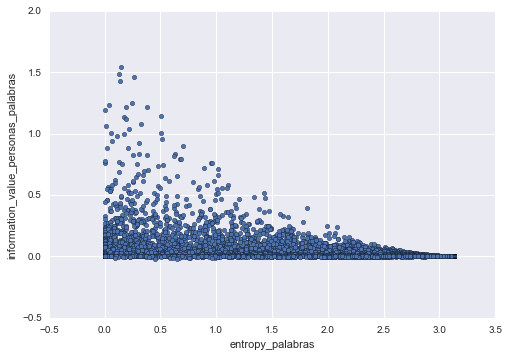

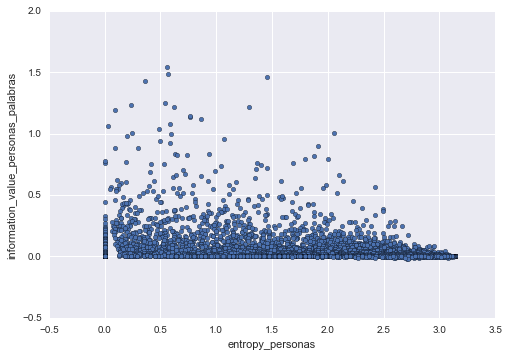

In [38]:
df.iloc[:1000].plot.scatter(x="rankPalabras_Personas", y="cantUsuariosTotal",ylim=[0,500])

df.plot.scatter(x="entropy_palabras", y="information_value_personas_palabras")
df.plot.scatter(x="entropy_personas", y="information_value_personas_palabras")


In [39]:
df.iloc[:5000][df.iloc[:5000].esLugar == 'lugar'].count()

buenosairesPalabras                    541
catamarcaPalabras                      541
chacoPalabras                          541
chubutPalabras                         541
cordobaPalabras                        541
corrientesPalabras                     541
entreriosPalabras                      541
formosaPalabras                        541
jujuyPalabras                          541
lapampaPalabras                        541
lariojaPalabras                        541
mendozaPalabras                        541
misionesPalabras                       541
neuquenPalabras                        541
rionegroPalabras                       541
saltaPalabras                          541
sanjuanPalabras                        541
sanluisPalabras                        541
santacruzPalabras                      541
santafePalabras                        541
santiagoPalabras                       541
tierradelfuegoPalabras                 541
tucumanPalabras                        541
cantPalabra